![](../images/logos.jpg "MiCMOR, KIT Campus Alpin")

**[MiCMOR](https://micmor.kit.edu) [SummerSchool "Environmental Data Science: From Data Exploration to Deep Learning"](https://micmor.kit.edu/sites/default/files/MICMoR%20Summer%20School%202019%20Flyer.pdf)**  
IMK-IFU KIT Campus Alpin, Sept. 4 - 13 2019, Garmisch-Partenkirchen, Germany.

---

# Deep Learning on tabular/ structured data

Based on: https://www.kaggle.com/abhikjha/fastai-pytorch-hooks-random-forest?source=post_page-----1748aa2b2f8c----------------------

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

import fastai
from fastai import *
from fastai.vision import *
from fastai.tabular import *

from fastai.callbacks.hooks import *
from fastai.callbacks.tracker import EarlyStoppingCallback, SaveModelCallback

#from utils import *
import sys

from scipy.special import erfinv
import matplotlib.pyplot as plt

import torch
#from torch.utils.data import *
from torch.optim import *
import torch.utils.data as Data
from fastai.basics import *
from fastai.callbacks.hooks import *
from tqdm import tqdm_notebook as tqdm

np.random.seed(42)

In [3]:
# helper functions
def to_gauss(x): 
    return np.sqrt(2)*erfinv(x)

def normalize(data, exclude=None):
    # if not binary, normalize it
    norm_cols = [n for n, c in data.drop(exclude, 1).items() if len(np.unique(c)) > 2]
    n = data.shape[0]
    for col in norm_cols:
        sorted_idx = data[col].sort_values().index.tolist()       # list of sorted index
        uniform = np.linspace(start=-0.99, stop=0.99, num=n)  
        normal = to_gauss(uniform)                                # apply gauss to linspace
        normalized_col = pd.Series(index=sorted_idx, data=normal) # sorted idx and normalized space
        data[col] = normalized_col                                # column receives its corresponding rank
    return data

In [19]:
# add column names
wilderness = [f'Wilderness_Area{i}' for i in range(1,5)]  # 4 one-hot-encoded wilderness types
soiltypes = [f'Soil_Type{i:02}' for i in range(1,41)]  # 40 one-hot-encoded soil types
colnames = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
            'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 
            'Horizontal_Distance_To_Fire_Points'] + wilderness + soiltypes + ['Cover_Type']


In [62]:
# read and transform one-hot cols into dense form
df = pd.read_csv('../data/uci/covtype/covtype.data.gz', compression='gzip', names=colnames, header=None, sep=',')
df['Soil'] = df.filter(like='Soil_Type').idxmax(axis=1).astype('category').cat.codes
df['Wilderness'] = df.filter(like='Wilderness_Area').idxmax(axis=1).astype('category').cat.codes
df = df[df.columns.drop(list(df.filter(regex='Soil_|Wilderness_')))]
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type,Soil,Wilderness
0,2596,51,3,258,0,510,221,232,148,6279,5,28,0
1,2590,56,2,212,-6,390,220,235,151,6225,5,28,0
2,2804,139,9,268,65,3180,234,238,135,6121,2,11,0
3,2785,155,18,242,118,3090,238,238,122,6211,2,29,0
4,2595,45,2,153,-1,391,220,234,150,6172,5,28,0


In [ ]:
df.info()

In [ ]:
procs=[FillMissing, Categorify]

cat_vars = ['Soil', 'Wilderness']

cont_vars = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 
             'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
             'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points'] 

dep_var = 'Cover_Type'

In [ ]:
df = normalize(df, exclude=cat_vars + [dep_var])

In [ ]:
data = (TabularList.from_df(df, path='.', cat_names=cat_vars, cont_names=cont_vars, procs=procs)
                .split_by_rand_pct(0.2, seed=42)
                .label_from_df(cols=dep_var)   #, label_cls=FloatList
                .databunch(bs=1024))

In [ ]:
data.show_batch()

In [ ]:
learn = tabular_learner(data, layers=[1000,500], metrics=accuracy, model_dir=".",
                        ps=[0.1, 0.1], emb_drop=0.04, emb_szs={'Soil': (40+1)//2, 'Wilderness': (4+1)//2})

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-03
Min loss divided by 10: 8.32E-03


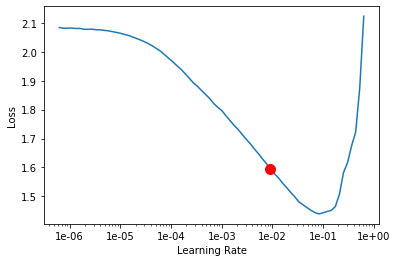

In [27]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [28]:
lr = 1e-2
learn.fit_one_cycle(5, max_lr=lr, wd=0.2, pct_start=0.3)

epoch,train_loss,valid_loss,accuracy,time
0,0.481920,0.438717,0.817714,00:05
1,0.401415,0.394419,0.835838,00:05
2,0.356772,0.325510,0.866775,00:05
3,0.280449,0.245712,0.900802,00:05
4,0.228914,0.200642,0.920234,00:05


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 7.59E-08


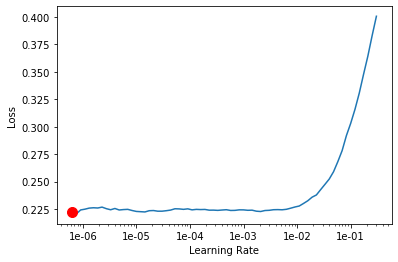

In [29]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [30]:
lr = 1e-4
learn.fit_one_cycle(5, lr, wd=0.2, pct_start=0.3)

epoch,train_loss,valid_loss,accuracy,time
0,0.222332,0.198518,0.921043,00:05
1,0.217958,0.194010,0.922893,00:05
2,0.215240,0.190627,0.924373,00:05
3,0.212408,0.188900,0.925199,00:05
4,0.210950,0.188585,0.925079,00:05


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-05
Min loss divided by 10: 1.91E-07


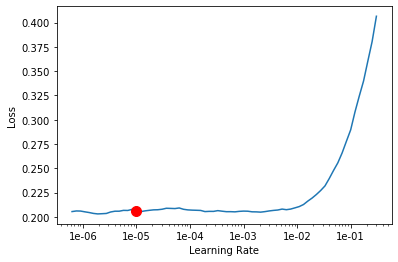

In [31]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [32]:
lr=1e-6
learn.fit_one_cycle(5, max_lr=lr, wd=0.2)

epoch,train_loss,valid_loss,accuracy,time
0,0.213429,0.188763,0.924958,00:05
1,0.209761,0.188362,0.925079,00:05
2,0.207629,0.188629,0.925001,00:05
3,0.210899,0.188617,0.925251,00:05
4,0.210806,0.188596,0.925242,00:05


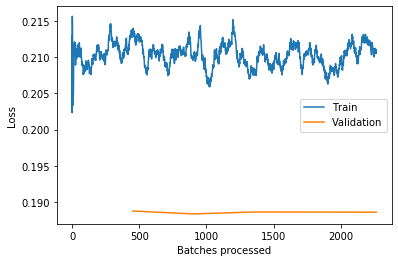

In [33]:
learn.save('1')
learn.recorder.plot_losses()

In [34]:
class SaveFeatures():
    features=None
    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
        self.features = None
    def hook_fn(self, module, input, output): 
        out = output.detach().cpu().numpy()
        if isinstance(self.features, type(None)):
            self.features = out
        else:
            self.features = np.row_stack((self.features, out))
    def remove(self): 
        self.hook.remove()

In [35]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(41, 20)
    (1): Embedding(5, 2)
  )
  (emb_drop): Dropout(p=0.04, inplace=False)
  (bn_cont): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=32, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=500, out_features=7, bias=True)
  )
)

In [36]:
sf = SaveFeatures(learn.model.layers[4])

In [37]:
_ = learn.get_preds(data.train_ds)

In [38]:
label = [x for x in (list(data.train_ds.y.items))]

In [39]:
len(label)

464810

In [40]:
df_new = pd.DataFrame({'label': label})
df_new.head()

,label
0,4
1,1
2,4
3,1
4,4


In [41]:
df_new['emb'] = np.array(sf.features).tolist()


In [42]:
df_new.head()

,label,emb
0,4,"[-8.640175819396973, -10.235847473144531, -12...."
1,1,"[-3.3153908252716064, -3.9060676097869873, -4...."
2,4,"[-8.06620979309082, -9.880215644836426, -11.51..."
3,1,"[-11.010101318359375, -13.740029335021973, -15..."
4,4,"[-7.63348388671875, -7.087619781494141, -8.378..."


In [43]:
d2 = pd.DataFrame(df_new.emb.values.tolist(), index = df_new.index).rename(columns = lambda x: f'emb{x+1}')

In [44]:
df_new_2 = df_new.join(d2)

In [45]:
df_new_2.shape

(464810, 502)

## Embeddings for Validation

In [46]:
sf = SaveFeatures(learn.model.layers[4])

In [47]:
_ = learn.get_preds(DatasetType.Valid)

In [48]:
label = [x for x in (list(data.valid_ds.y.items))]

In [49]:
df_new_valid = pd.DataFrame({'label': label})

In [50]:
df_new_valid['emb'] = np.array(sf.features).tolist()

In [51]:
d2 = pd.DataFrame(df_new_valid.emb.values.tolist(), index = df_new_valid.index).rename(columns = lambda x: f'emb{x+1}')

In [52]:
df_new_valid_2 = df_new_valid.join(d2)

In [53]:
df_new_valid_2.drop(['emb'], axis=1, inplace=True)
df_new_2.drop(['emb'], axis=1, inplace=True)

In [54]:
corr_matrix = df_new_2.corr()
corr_matrix["label"].sort_values(ascending = False)

label     1.000000
emb390    0.328139
emb468    0.307485
emb251    0.301199
emb424    0.291241
            ...   
emb410   -0.365542
emb207   -0.368215
emb221   -0.370327
emb56    -0.393971
emb162   -0.396042
Name: label, Length: 501, dtype: float64

In [55]:
X = df_new_2
y = df_new_2.label.copy()

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [56]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((371848, 501), (371848,), (92962, 501), (92962,))

In [57]:
y_train = X_train.label
X_train = X_train.drop("label", axis =1)

y_test = X_test.label
X_test = X_test.drop("label", axis =1)

In [58]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((371848, 500), (371848,), (92962, 500), (92962,))

In [59]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, attributes_names):
        self.attributes_names = attributes_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.attributes_names].values

In [60]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# numerical pipeline

num_pipeline = Pipeline([
    
    ('select_data', DataFrameSelector(X_train.columns)),
    ('Std_Scaler', StandardScaler())
])

X_train_transformed = num_pipeline.fit_transform(X_train)
X_test_transformed = num_pipeline.fit_transform(X_test)

In [166]:
X_train_transformed.shape, X_test_transformed.shape

((371848, 500), (92962, 500))

In [61]:
from sklearn.ensemble import RandomForestClassifier
import time

start = time.time()

rf_clf = RandomForestClassifier(bootstrap=True,
            criterion='gini', max_depth=15, max_features=0.5,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=3,
            min_samples_split=8, min_weight_fraction_leaf=0.0,
            n_estimators=185, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

rf_clf.fit(X_train_transformed, y_train)

end = time.time()

print("run_time:", (end-start)/(60*60))

KeyboardInterrupt: 

In [ ]:
a

## Prediction

In [ ]:
from sklearn.model_selection import cross_val_predict, cross_val_score

import time

start = time.time()

score_rf = cross_val_score(rf_clf, X_train_transformed, y_train, cv=5, scoring='neg_mean_squared_error', verbose=0)
print(score_rf.mean())

end = time.time()

print("run_time:", (end-start)/(60*60))

In [ ]:
y_pred_test_rf = rf_clf.predict(X_test_transformed)

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred_test_rf)

In [100]:
X = df_new_valid_2
y = df_new_valid_2.label.copy()

In [101]:
X_val = X.drop("label", axis =1)
y_val = y

In [102]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# numerical pipeline

num_pipeline = Pipeline([
    
    ('select_data', DataFrameSelector(X_val.columns)),
    ('Std_Scaler', StandardScaler())
])


X_val_transformed = num_pipeline.fit_transform(X_val)

In [103]:
y_pred_test_rf_val = rf_clf.predict(X_val_transformed)

NameError: name 'rf_clf' is not defined

In [105]:
from sklearn.metrics import accuracy_score
accuracy_score(y_val, y_pred_test_rf_val)

NameError: name 'y_pred_test_rf_val' is not defined